# Relations réciproques entres personnes et avec les institutions

In [102]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
import numpy as np
import seaborn as sns
from netgraph import Graph, InteractiveGraph
from pyvis.network import Network
import math

## Production des données

* Requête exécutée sur le serveur https://dbpedia.org/sparql 
* Période élargie jusqu'aux comtemporains-nes
* Propriétés prises en compte après inspection des propriétés de la population:
  * http://dbpedia.org/ontology/almaMater 
  * http://dbpedia.org/ontology/institution


```SPARQL
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT (?o1 AS ?subject_uri) ?subjectBirthDate ?r_property ?target (xsd:integer(SUBSTR(STR(?normalizedDate), 1, 4)) AS ?birthYear)
WHERE {
  SELECT DISTINCT ?o1 ?subjectBirthDate ?r_property ?target (STRDT(REPLACE(STR(?subjectBirthDate), "[^0-9\\-]", ""), xsd:date) AS ?normalizedDate)
  WHERE {
    ?o1 ?p dbr:Poet.
    ?o1 a dbo:Person;
      (dbp:birthDate | dbo:birthDate) ?subjectBirthDate.
    {
      {?o1 dbo:almaMater ?target.
       BIND('almaMater' AS ?r_property)}
      UNION
      {?o1 dbo:institution ?target.
       BIND('institution' AS ?r_property)}
      #UNION
      #{?o1 dbp:fields ?target.
      # BIND('fields' AS ?r_property)}
      #UNION
      #{?o1 dbp:field ?target.
      # BIND('field' AS ?r_property)}
    }
  }
}
ORDER BY ?birthYear

```

In [103]:
path = 'data/poets_relations.csv'

df = pd.read_csv(path)

### Inspecter les dimensions et les 3 premières et dernières lignes
print(df.shape, df.head(5), '\n\n-----\n', df.tail(5))

(1869, 1)   subject_uri;subjectBirthDate;r_property;target;birthYear
0  http://dbpedia.org/resource/Anna_Smaill;1979  ...      
1  http://dbpedia.org/resource/Anna_Smaill;1979  ...      
2  http://dbpedia.org/resource/Anna_Smaill;1979  ...      
3  http://dbpedia.org/resource/Vladimir_Mayakovsk...      
4  http://dbpedia.org/resource/Vladimir_Mayakovsk...       

-----
      subject_uri;subjectBirthDate;r_property;target;birthYear
1864  http://dbpedia.org/resource/Pratyush_Prakash;3...      
1865  http://dbpedia.org/resource/Cyrus_Grace_Dunham...      
1866  http://dbpedia.org/resource/Amata_Giramata;350...      
1867  http://dbpedia.org/resource/Amata_Giramata;350...      
1868  http://dbpedia.org/resource/Amanda_Gorman;3586...      


In [214]:
### Ouvrir le fichier et créer un DataFrame
fd = 'data/poets_relations.csv'
df = pd.read_csv(fd)
len(df)

1869

In [215]:
# Spécifiez le délimiteur lors de la lecture du fichier CSV
df = pd.read_csv('data/poets_relations.csv', delimiter=';')

# Effectuez vos opérations sur le DataFrame
# ...

# Exemple : affichez les premières lignes du DataFrame
print(df.head())

                                       subject_uri subjectBirthDate   
0          http://dbpedia.org/resource/Anna_Smaill         1979      \
1          http://dbpedia.org/resource/Anna_Smaill         1979       
2          http://dbpedia.org/resource/Anna_Smaill         1979       
3  http://dbpedia.org/resource/Vladimir_Mayakovsky       0001-07-19   
4  http://dbpedia.org/resource/Vladimir_Mayakovsky       0001-07-19   

  r_property                                             target  birthYear  
0  almaMater  http://dbpedia.org/resource/University_College...        NaN  
1  almaMater  http://dbpedia.org/resource/University_of_Auck...        NaN  
2  almaMater  http://dbpedia.org/resource/Victoria_Universit...        NaN  
3  almaMater  http://dbpedia.org/resource/Moscow_School_of_P...        NaN  
4  almaMater  http://dbpedia.org/resource/Stroganov_Moscow_S...        NaN  


In [107]:
### Raccourcir l'URI, extraire l'année de naissance
df['subject_uri'] = df['subject_uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['target'] = df['target'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['BirthYear'] = df['subjectBirthDate'].apply(lambda x : int(x[:4]) if isinstance(x, str) else x)

In [108]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'insitution' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 17) if x['r_property'] == 'almaMater' and not math.isnan(x['BirthYear']) else None, axis=1)
df['YEnd'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 28) if x['r_property'] == 'almaMater' and not math.isnan(x['BirthYear']) else None, axis=1)

In [109]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_uri       1869 non-null   object 
 1   subjectBirthDate  1868 non-null   object 
 2   r_property        1869 non-null   object 
 3   target            1869 non-null   object 
 4   birthYear         1643 non-null   float64
 5   BirthYear         1868 non-null   float64
 6   YBegin            1861 non-null   float64
 7   YEnd              1861 non-null   float64
dtypes: float64(4), object(4)
memory usage: 116.9+ KB


In [110]:
### Inspecter la distribution des années de naissance
df.BirthYear.describe()

count    1868.000000
mean     2476.365096
std      1860.592301
min         1.000000
25%      1626.750000
50%      1890.000000
75%      2382.000000
max      9918.000000
Name: BirthYear, dtype: float64

In [111]:
### Inspecter la table 
# https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(df[['subject_uri','r_property','target','YBegin','YEnd','BirthYear']].sort_values(by='BirthYear'), classes="display", scrollY="200px", 
     scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [112]:
### Compter par propriété
df.groupby(by='r_property').size()

r_property
almaMater      1862
institution       7
dtype: int64

In [113]:
# l_org_orig = list(df.target.unique()); len(l_org_orig), l_org_orig[:3]

In [114]:
### Effectuer et documenter tous les changements: nettoyage des données
df.loc[df.target == 'École_normale_supérieure_(Ulm)', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_normale_supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Superieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'Swiss_Federal_Polytechnic', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Federal_Polytechnic_School', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Swiss_Federal_Institute_of_Technology_at_Zurich', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'École_polytechnique', 'target']  = 'École_Polytechnique'
df.loc[df.target == 'University_of_Padua', 'target']  = 'Università_di_Padova'
df.loc[df.target == 'University_of_Padova', 'target']  = 'Università_di_Padova'

In [115]:
### Remplacements multiples, contenant Paris et Université
df.loc[(df.target.str.contains('Paris')) & (df.target.str.contains('Univ')), 'target'] = "Université_de_Paris"

In [116]:
organisations = df.groupby(by='target').size()
show(organisations.sort_index(ascending=False))

In [117]:
### Effectif total et les plus représentées
len(organisations), organisations.sort_values(ascending=False).head(10)

(852,
 target
 Harvard_University         36
 Columbia_University        33
 University_of_Michigan     19
 University_of_Coimbra      19
 Université_de_Paris        18
 University_of_Edinburgh    16
 University_of_Iowa         15
 University_of_Dhaka        14
 University_of_São_Paulo    14
 University_of_Belgrade     13
 dtype: int64)

### Explorer les années de naissance

In [118]:
s = df.BirthYear

(1801.0, 1900.0)

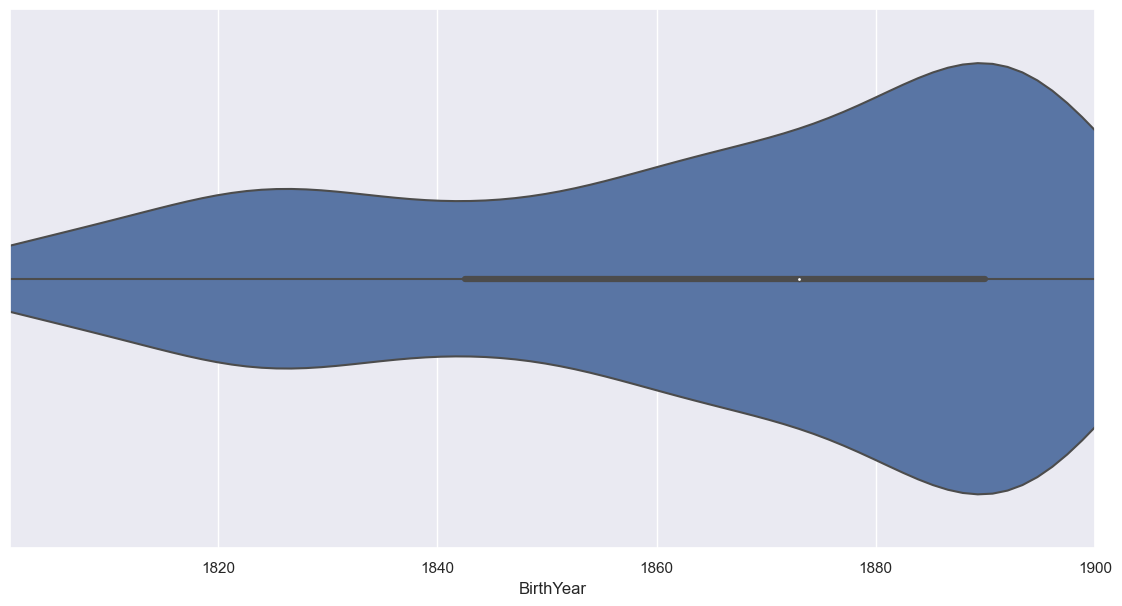

In [119]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

### Personnes nées avant 1931 (protection des données)
# a = s[(s<1931)] 
## Période pré-scientifique
a = s[(s<1801)]
## Décollage de la science 'moderne'
a = s[(s>1800) & (s<1901)] # 
## Science contemporaine
# a = s[(s>1900) ] # 
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


#### Coder les périodes

In [120]:
bins=[1001,1801,1901,2021]

In [121]:
df['periode'] = pd.cut(df['BirthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [122]:
df.head()

,subject_uri,subjectBirthDate,r_property,target,birthYear,BirthYear,YBegin,YEnd,periode
0,Anna_Smaill,1979,almaMater,University_College_London,NaN,1979.0,1996.0,2007.0,1901_2021
1,Anna_Smaill,1979,almaMater,University_of_Auckland,NaN,1979.0,1996.0,2007.0,1901_2021
2,Anna_Smaill,1979,almaMater,Victoria_University_of_Wellington,NaN,1979.0,1996.0,2007.0,1901_2021
3,Vladimir_Mayakovsky,0001-07-19,almaMater,Moscow_School_of_Painting_Sculpture_and_Archit...,NaN,1.0,18.0,29.0,NaN
4,Vladimir_Mayakovsky,0001-07-19,almaMater,Stroganov_Moscow_State_University_of_Arts_and_...,NaN,1.0,18.0,29.0,NaN


In [123]:
### Effectif par période
df.groupby(by='periode').size()

periode
1001_1801    631
1801_1901    351
1901_2021    238
dtype: int64

In [124]:
### Dataframe to dictionary
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['subject_uri', 'r_property', 'target',
       'YBegin', 'YEnd', 'BirthYear', 'periode']].sort_values(by='subject_uri').to_dict('records')

In [125]:
ldf[:2]

[{'subject_uri': 'A._D._Hope',
  'r_property': 'almaMater',
  'target': 'University_of_Sydney',
  'YBegin': 2776.0,
  'YEnd': 2787.0,
  'BirthYear': 2759.0,
  'periode': nan},
 {'subject_uri': 'A._D._Hope',
  'r_property': 'almaMater',
  'target': 'University_College_Oxford',
  'YBegin': 2776.0,
  'YEnd': 2787.0,
  'BirthYear': 2759.0,
  'periode': nan}]

## Graphe à deux types de sommets


Il s'agit d'un graphe de type 'bipartite', cf. la documentation de Networkx:

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

Nous n'utilisons toutefois pas ici les fonctions spécifiques de Neworkx.

In [126]:
l = []
for i in ldf:
    if i['periode'] == '1001_1801':
        l.append(tuple((i['subject_uri'],i['target'], 
                        {'relationship': i['r_property'], "birth_year": i['BirthYear'], "periode": i['periode'] })))
l[:5]

[('A._J._M._Smith',
  'McGill_University',
  {'relationship': 'almaMater', 'birth_year': 1043.0, 'periode': '1001_1801'}),
 ('A._J._M._Smith',
  'University_of_Edinburgh',
  {'relationship': 'almaMater', 'birth_year': 1043.0, 'periode': '1001_1801'}),
 ('A._K._Ramanujan',
  'Deccan_College_(Pune)',
  {'relationship': 'almaMater', 'birth_year': 1066.0, 'periode': '1001_1801'}),
 ('A._K._Ramanujan',
  'University_of_Mysore',
  {'relationship': 'almaMater', 'birth_year': 1066.0, 'periode': '1001_1801'}),
 ('A._K._Ramanujan',
  'Indiana_University',
  {'relationship': 'almaMater', 'birth_year': 1066.0, 'periode': '1001_1801'})]

In [127]:
# Graphe Personne- Organisation
POG=nx.Graph()

In [128]:
POG.add_edges_from(l)

In [129]:
### Principales caractéristiques de ce graphe

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)


(False, False, False, 771, 557, 0.0018764633550625769)

In [130]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:3]

['Abdul_Wali_Khan_University_Mardan',
 'Aberystwyth_University',
 'Academic_Gymnasium_Danzig']

In [131]:
list(POG.nodes.data())[:4]

[('A._J._M._Smith', {}),
 ('McGill_University', {}),
 ('University_of_Edinburgh', {}),
 ('A._K._Ramanujan', {})]

In [132]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('A._J._M._Smith', {'type': 'P'}),
 ('McGill_University', {'type': 'O'}),
 ('University_of_Edinburgh', {'type': 'O'})]

In [133]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('A._J._M._Smith', {'type': 'P'}),
 ('McGill_University', {'type': 'O'}),
 ('University_of_Edinburgh', {'type': 'O'})]

### Inspecter les centralités de degré

In [134]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [135]:
nx.set_node_attributes(POG, degree)

In [136]:
print(list(POG.nodes.data())[:4])

[('A._J._M._Smith', {'type': 'P', 'degree': 2}), ('McGill_University', {'type': 'O', 'degree': 1}), ('University_of_Edinburgh', {'type': 'O', 'degree': 5}), ('A._K._Ramanujan', {'type': 'P', 'degree': 3})]


In [137]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [138]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['George_Starbuck', 6],
 ['Joan_Retallack', 4],
 ['Richard_Eberhart', 4],
 ['Robert_L._Lynn', 4],
 ['Sharon_Olds', 4],
 ['Sidney_Farber', 4],
 ['A._K._Ramanujan', 3],
 ['Aad_Nuis', 3],
 ['Abhi_Subedi', 3],
 ['Anwar_Masood', 3]]

In [139]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [140]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['Columbia_University', 12],
 ['University_of_Coimbra', 10],
 ['University_of_Michigan', 9],
 ['Harvard_University', 9],
 ['Trinity_College_Cambridge', 6],
 ['Maxim_Gorky_Literature_Institute', 6],
 ['Université_de_Paris', 6],
 ["St_John's_College_Cambridge", 6],
 ['University_of_Edinburgh', 5],
 ['University_of_Dhaka', 5]]

In [141]:
edges = list(POG.edges.data())
edges[:5]

[('A._J._M._Smith',
  'McGill_University',
  {'relationship': 'almaMater', 'birth_year': 1043.0, 'periode': '1001_1801'}),
 ('A._J._M._Smith',
  'University_of_Edinburgh',
  {'relationship': 'almaMater', 'birth_year': 1043.0, 'periode': '1001_1801'}),
 ('University_of_Edinburgh',
  'Abhi_Subedi',
  {'relationship': 'almaMater', 'birth_year': 1661.0, 'periode': '1001_1801'}),
 ('University_of_Edinburgh',
  'James_Thomson',
  {'relationship': 'almaMater', 'birth_year': 1700.0, 'periode': '1001_1801'}),
 ('University_of_Edinburgh',
  'Tobias_Smollett',
  {'relationship': 'almaMater', 'birth_year': 1721.0, 'periode': '1001_1801'})]

In [142]:
labels = {}    
for node in POG.nodes():
    labels[node] = node

In [143]:
nx.set_node_attributes(POG, labels, 'label')

In [144]:
nodes = list(POG.nodes.data())
nodes[:5]

[('A._J._M._Smith', {'type': 'P', 'degree': 2, 'label': 'A._J._M._Smith'}),
 ('McGill_University',
  {'type': 'O', 'degree': 1, 'label': 'McGill_University'}),
 ('University_of_Edinburgh',
  {'type': 'O', 'degree': 5, 'label': 'University_of_Edinburgh'}),
 ('A._K._Ramanujan', {'type': 'P', 'degree': 3, 'label': 'A._K._Ramanujan'}),
 ('Deccan_College_(Pune)',
  {'type': 'O', 'degree': 1, 'label': 'Deccan_College_(Pune)'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [145]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(215, [93, 23, 15, 14, 14])

In [146]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [147]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[1, 93], [65, 23], [55, 15], [0, 14], [26, 14], [19, 11], [36, 11], [7, 8]]

In [148]:
li=[n[0] for n in ln]

In [149]:
S[21].nodes 

NodeView(('Anabel_Torres', 'Institute_of_Social_Studies'))

### Représenter le graphe

In [150]:
u = S[14]

In [151]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [152]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, False, 159, 155, 0.012339781864501234)

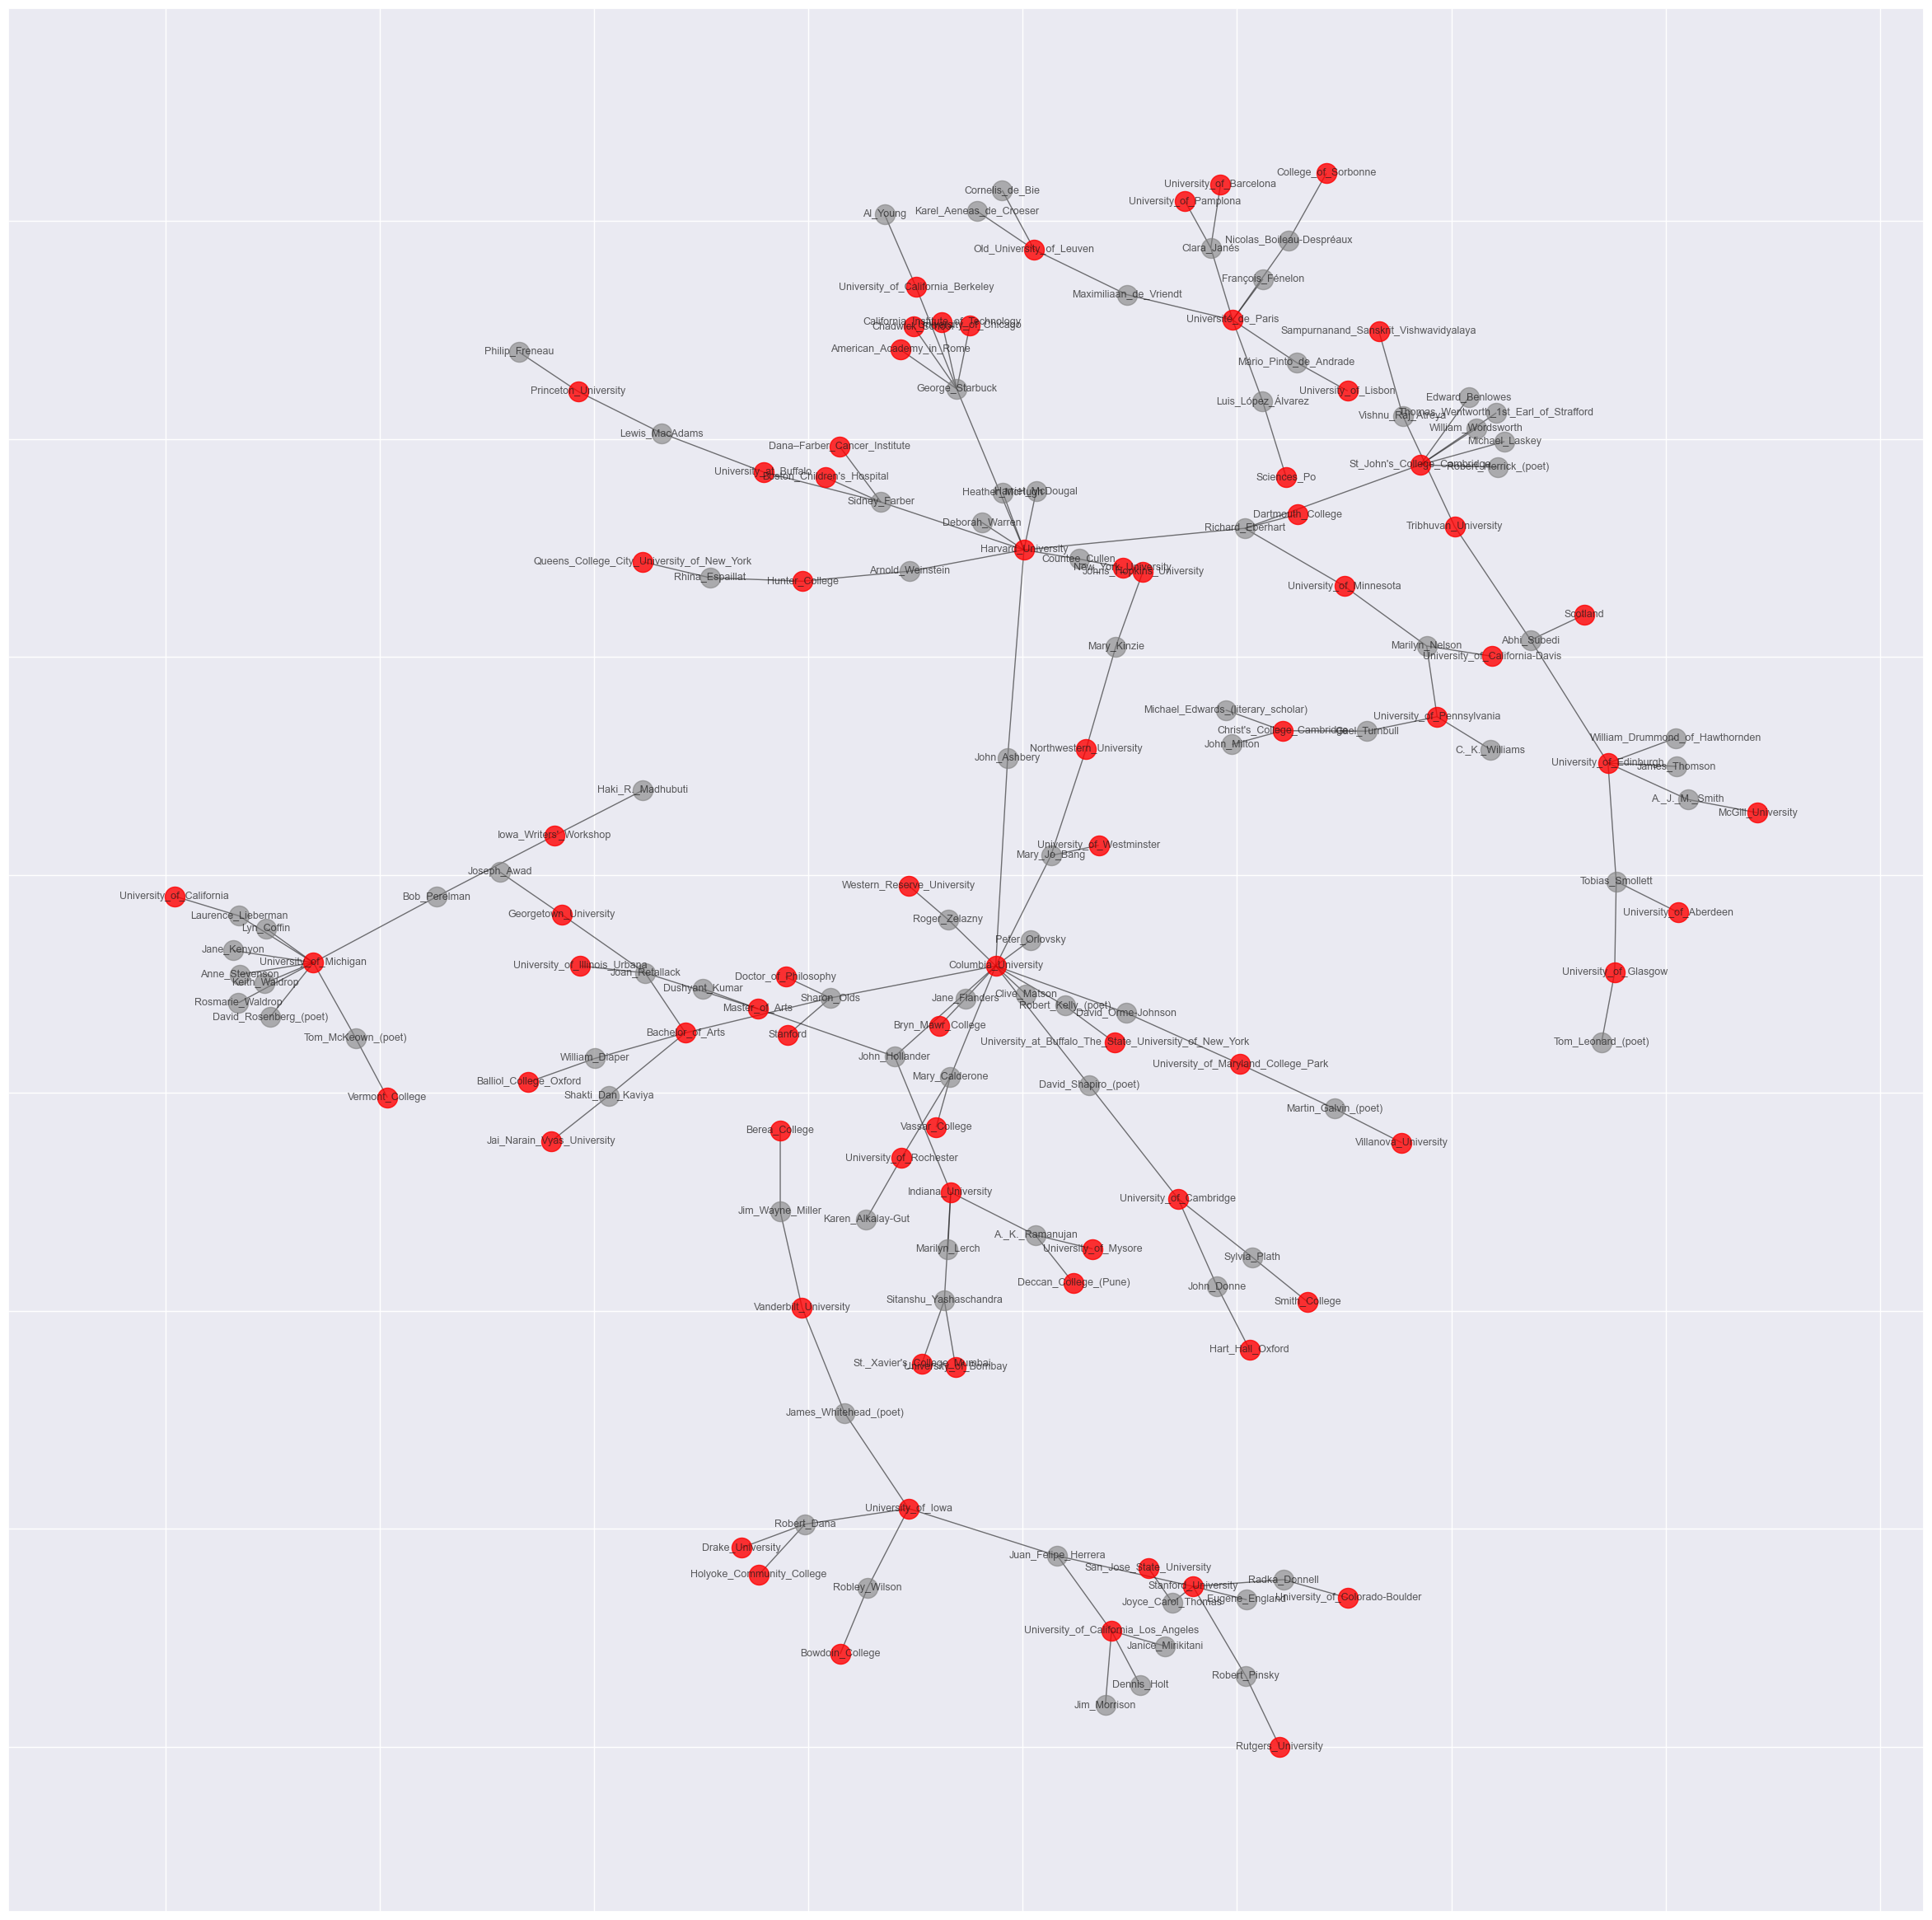

In [153]:
### Visualiser les "écoles", i.e. quelles personnes 
# ont étudié dans la même Université
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()


In [154]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(g)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [155]:
nt.prep_notebook()
nt.show('pictures/nx.html' )

### Créer les paires de personnes

Personnes ayant étudié dans la même univerisité, à la même époque:

* on teste si c'est la même université
* on teste s'il y a superposition des périodes

In [156]:
### Pairs de personnes
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['subject_uri'] < s2['subject_uri'] \
            and s1['target'] == s2['target'] \
            and s2['YEnd'] > s1['YBegin'] \
            and s2['YBegin'] < s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [157]:
len(pairs_p)

160

In [158]:
pairs_p[:2]

[[{'subject_uri': 'Aaron_McCollough',
   'r_property': 'almaMater',
   'target': "Iowa_Writers'_Workshop",
   'YBegin': 1988.0,
   'YEnd': 1999.0,
   'BirthYear': 1971.0,
   'periode': '1901_2021'},
  {'subject_uri': 'Ben_Doller',
   'r_property': 'almaMater',
   'target': "Iowa_Writers'_Workshop",
   'YBegin': 1990.0,
   'YEnd': 2001.0,
   'BirthYear': 1973.0,
   'periode': '1901_2021'}],
 [{'subject_uri': 'Aaron_McCollough',
   'r_property': 'almaMater',
   'target': "Iowa_Writers'_Workshop",
   'YBegin': 1988.0,
   'YEnd': 1999.0,
   'BirthYear': 1971.0,
   'periode': '1901_2021'},
  {'subject_uri': 'Ben_Doller',
   'r_property': 'almaMater',
   'target': "Iowa_Writers'_Workshop",
   'YBegin': 1990.0,
   'YEnd': 2001.0,
   'BirthYear': 1973.0,
   'periode': '1901_2021'}]]

### Créer les pairs d'organisations

Une personne fait le lien entre deux organisations

In [159]:
## Pairs d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['target'] < s2['target'] \
            and s1['subject_uri'] == s2['subject_uri']:
                pairs_o.append([s1,s2])
        else:
            pass

In [160]:
len(pairs_o)

922

In [161]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_College_Oxford',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan},
  {'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_of_Sydney',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan}],
 [{'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_College_Oxford',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan},
  {'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_of_Sydney',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan}]]

## Réseaux de personnes (filtres, sous-populations)

In [162]:
earlyModern_pairs = [p for p in pairs_p if ((p[0]['periode']=='1001_1801') & (p[1]['periode']=='1001_1801'))]

In [163]:
len(earlyModern_pairs), earlyModern_pairs[:3]

(28,
 [[{'subject_uri': 'Aleksey_Merzlyakov',
    'r_property': 'almaMater',
    'target': 'Imperial_Moscow_University',
    'YBegin': 1795.0,
    'YEnd': 1806.0,
    'BirthYear': 1778.0,
    'periode': '1001_1801'},
   {'subject_uri': 'Nikolay_Gnedich',
    'r_property': 'almaMater',
    'target': 'Imperial_Moscow_University',
    'YBegin': 1801.0,
    'YEnd': 1812.0,
    'BirthYear': 1784.0,
    'periode': '1001_1801'}],
  [{'subject_uri': 'Alvarenga_Peixoto',
    'r_property': 'almaMater',
    'target': 'University_of_Coimbra',
    'YBegin': 1761.0,
    'YEnd': 1772.0,
    'BirthYear': 1744.0,
    'periode': '1001_1801'},
   {'subject_uri': 'Domingos_Caldas_Barbosa',
    'r_property': 'almaMater',
    'target': 'University_of_Coimbra',
    'YBegin': 1756.0,
    'YEnd': 1767.0,
    'BirthYear': 1739.0,
    'periode': '1001_1801'}],
  [{'subject_uri': 'Alvarenga_Peixoto',
    'r_property': 'almaMater',
    'target': 'University_of_Coimbra',
    'YBegin': 1761.0,
    'YEnd': 1772.0,
  

In [164]:
almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'almaMater') & (p[1]['r_property'] == 'almaMater'))]

In [165]:
len(almaMater_pairs), almaMater_pairs[:2]

(160,
 [[{'subject_uri': 'Aaron_McCollough',
    'r_property': 'almaMater',
    'target': "Iowa_Writers'_Workshop",
    'YBegin': 1988.0,
    'YEnd': 1999.0,
    'BirthYear': 1971.0,
    'periode': '1901_2021'},
   {'subject_uri': 'Ben_Doller',
    'r_property': 'almaMater',
    'target': "Iowa_Writers'_Workshop",
    'YBegin': 1990.0,
    'YEnd': 2001.0,
    'BirthYear': 1973.0,
    'periode': '1901_2021'}],
  [{'subject_uri': 'Aaron_McCollough',
    'r_property': 'almaMater',
    'target': "Iowa_Writers'_Workshop",
    'YBegin': 1988.0,
    'YEnd': 1999.0,
    'BirthYear': 1971.0,
    'periode': '1901_2021'},
   {'subject_uri': 'Ben_Doller',
    'r_property': 'almaMater',
    'target': "Iowa_Writers'_Workshop",
    'YBegin': 1990.0,
    'YEnd': 2001.0,
    'BirthYear': 1973.0,
    'periode': '1901_2021'}]])

## Exploration des graphes de personnes

In [166]:
### Préparer pour créer le graphe
l = []
for i in earlyModern_pairs: #almaMater_pairs:
    l.append(tuple((i[0]['subject_uri'],i[1]['subject_uri'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'organisation': i[0]['target'] })))
l[:5]

[('Aleksey_Merzlyakov',
  'Nikolay_Gnedich',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'Imperial_Moscow_University'}),
 ('Alvarenga_Peixoto',
  'Domingos_Caldas_Barbosa',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'}),
 ('Alvarenga_Peixoto',
  'Manuel_Inácio_da_Silva_Alvarenga',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'}),
 ('Alvarenga_Peixoto',
  'Tomás_António_Gonzaga',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'}),
 ('Alvarenga_Peixoto',
  'Domingos_Caldas_Barbosa',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'})]

In [167]:
EMP=nx.Graph()

In [168]:
EMP.add_edges_from(l)

In [169]:
### Principales caractéristiques de ce graphe

EMP.is_multigraph(), EMP.is_directed(), nx.is_connected(EMP), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP)


(False, False, False, 29, 20, 0.04926108374384237)

In [170]:
nodes = list(EMP.nodes.data())
nodes[:5]

[('Aleksey_Merzlyakov', {}),
 ('Nikolay_Gnedich', {}),
 ('Alvarenga_Peixoto', {}),
 ('Domingos_Caldas_Barbosa', {}),
 ('Manuel_Inácio_da_Silva_Alvarenga', {})]

In [171]:
edges = list(EMP.edges.data())
edges[:5]

[('Aleksey_Merzlyakov',
  'Nikolay_Gnedich',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'Imperial_Moscow_University'}),
 ('Alvarenga_Peixoto',
  'Domingos_Caldas_Barbosa',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'}),
 ('Alvarenga_Peixoto',
  'Manuel_Inácio_da_Silva_Alvarenga',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'}),
 ('Alvarenga_Peixoto',
  'Tomás_António_Gonzaga',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'}),
 ('Domingos_Caldas_Barbosa',
  'Cláudio_Manuel_da_Costa',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Coimbra'})]

In [172]:
labels = {}    
for node in EMP.nodes():
    labels[node] = node

In [173]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(EMP)
nt.prep_notebook()
nt.show('pictures/emp.html' )

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [174]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(12, [6, 3, 2, 2, 2])

In [175]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [176]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[1, 6], [8, 3], [0, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2]]

In [177]:
li=[n[0] for n in ln]

### Représenter le graphe

In [178]:
u = nx.Graph()
for i in li[1:3]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [179]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, False, 5, 3, 0.3)

In [180]:
u = S[5]

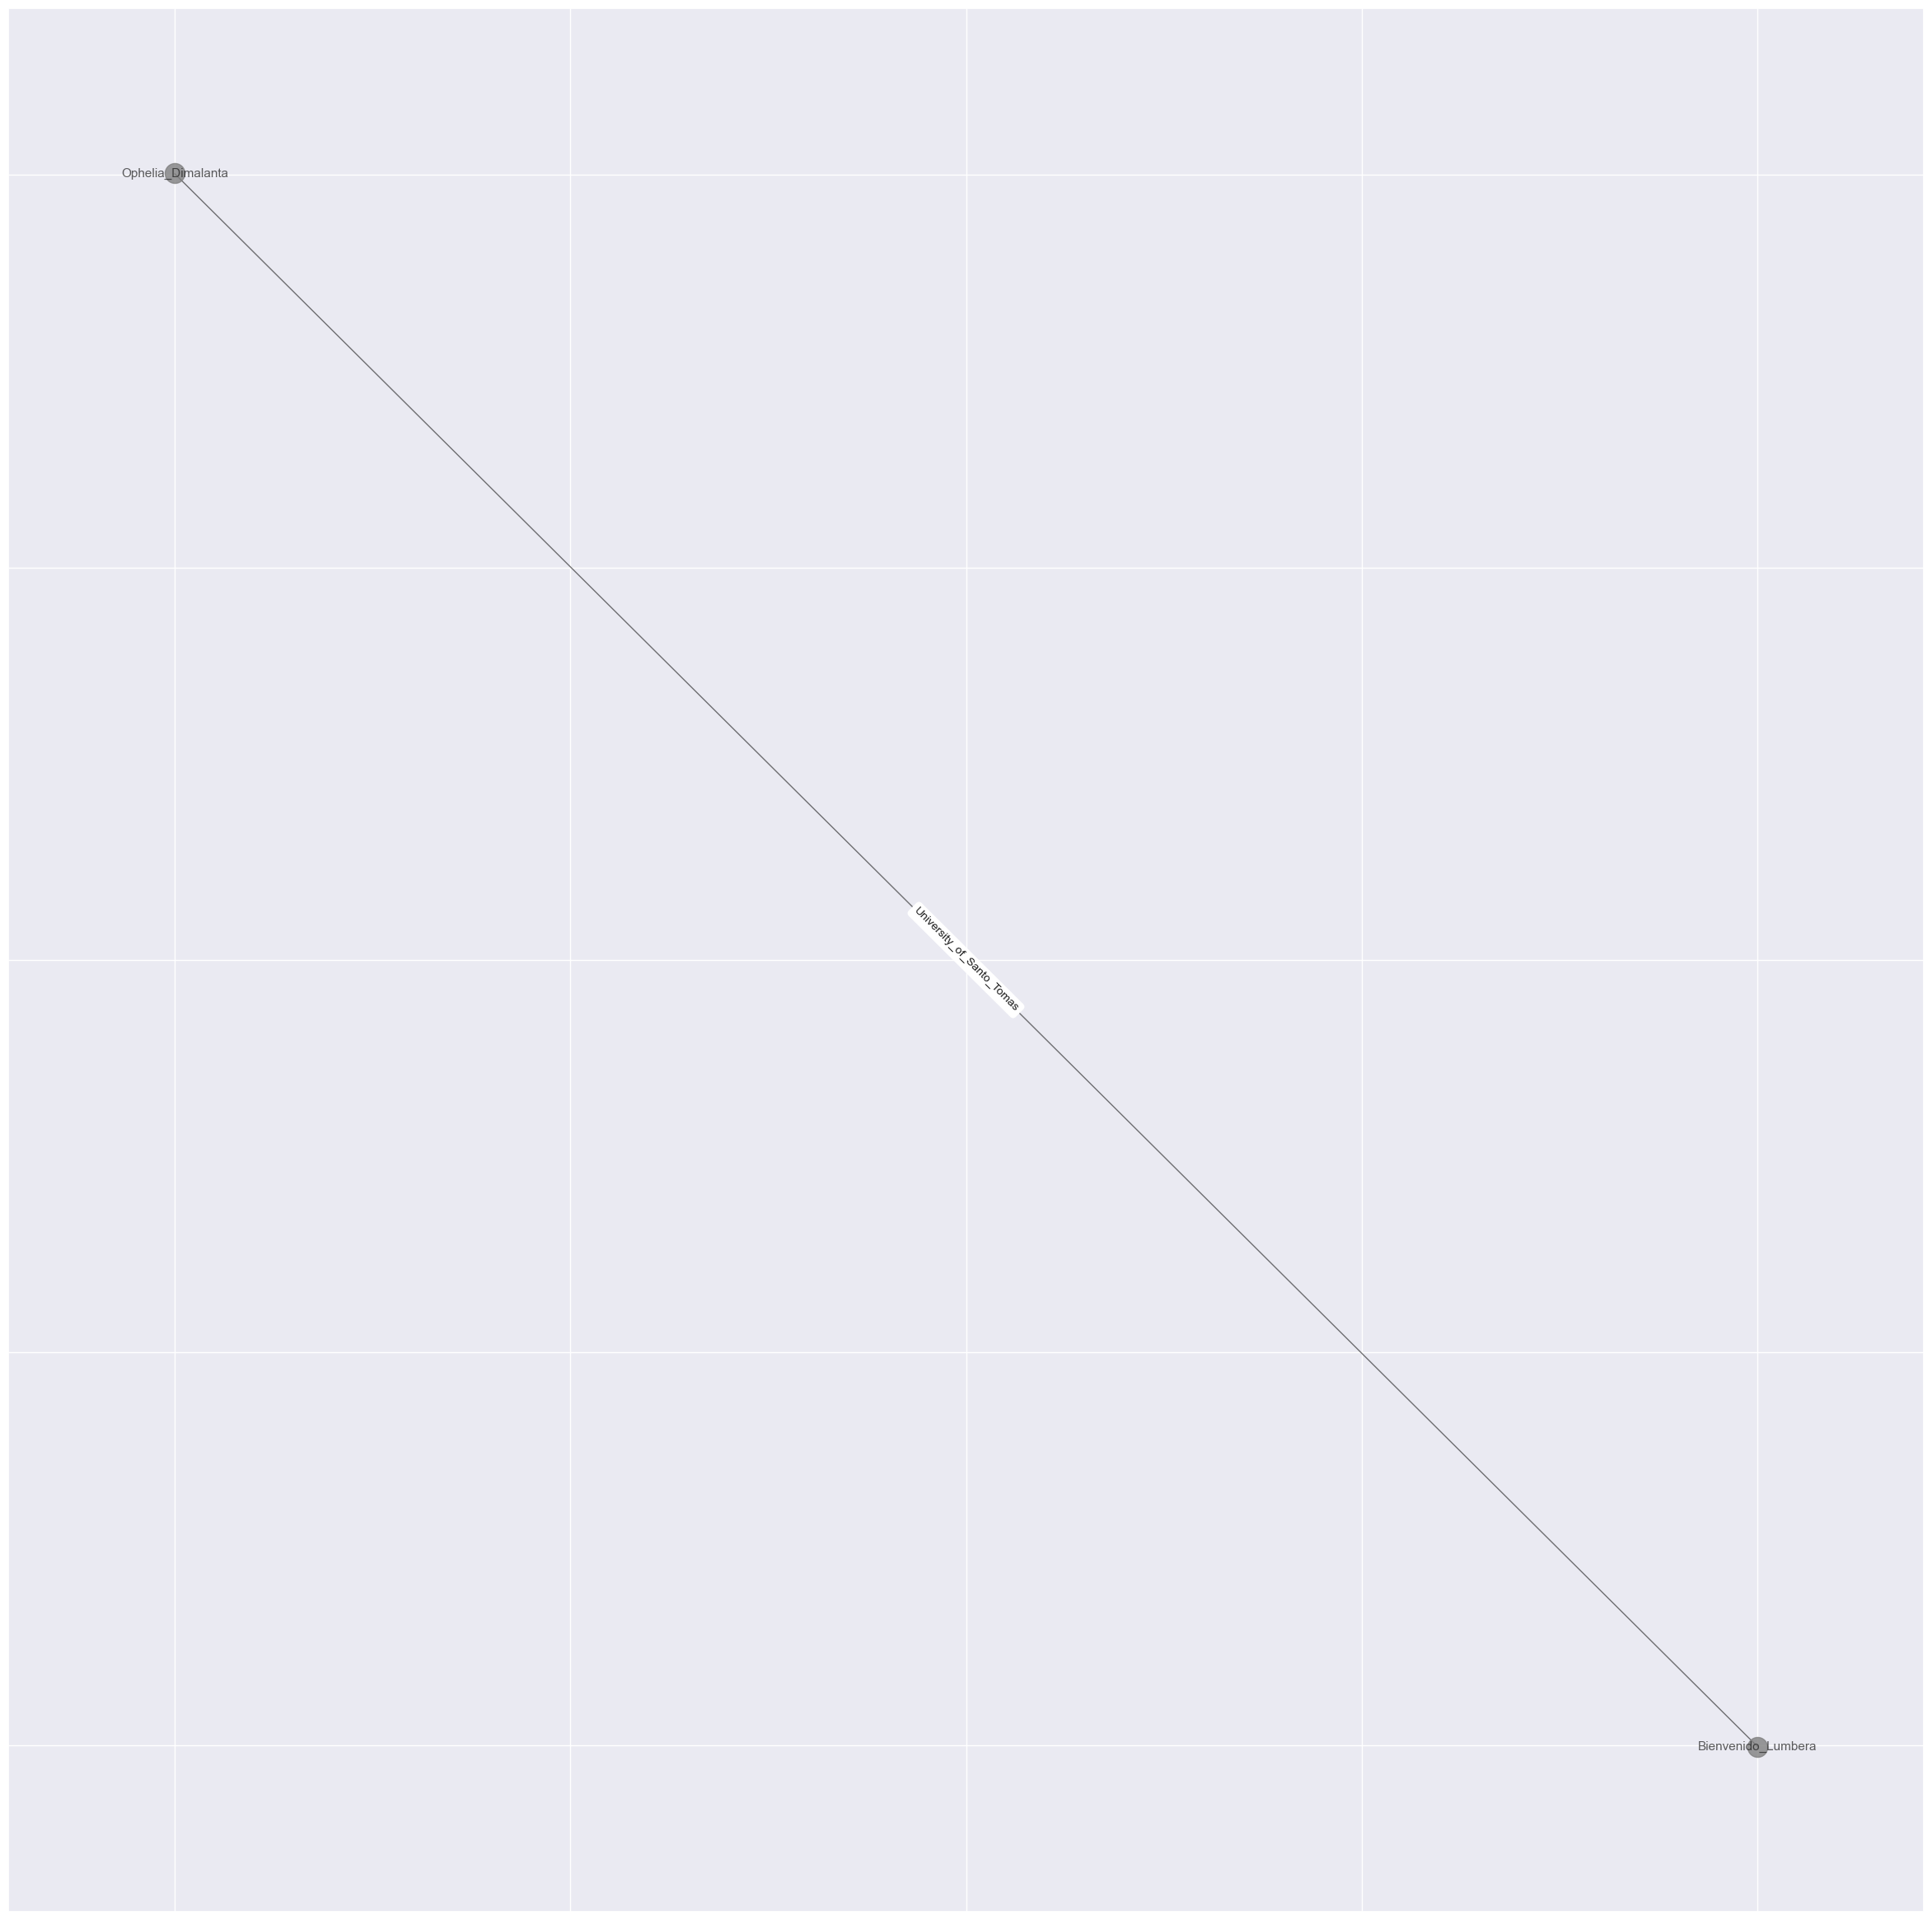

In [181]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)



plt.show()


## Explorer le graphe des organisations (relation Alma Mater)

In [182]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_College_Oxford',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan},
  {'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_of_Sydney',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan}],
 [{'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_College_Oxford',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan},
  {'subject_uri': 'A._D._Hope',
   'r_property': 'almaMater',
   'target': 'University_of_Sydney',
   'YBegin': 2776.0,
   'YEnd': 2787.0,
   'BirthYear': 2759.0,
   'periode': nan}]]

In [183]:
l = []
for i in pairs_o:
    if i[0]['r_property'] == 'almaMater' or  i[1]['r_property'] == 'almaMater':
        l.append(tuple((i[0]['target'],i[1]['target'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'personne': i[0]['subject_uri'] })))
len(l), l[:3]        

(920,
 [('University_College_Oxford',
   'University_of_Sydney',
   {'relationship': 'almaMater_almaMater', 'personne': 'A._D._Hope'}),
  ('University_College_Oxford',
   'University_of_Sydney',
   {'relationship': 'almaMater_almaMater', 'personne': 'A._D._Hope'}),
  ('McGill_University',
   'University_of_Edinburgh',
   {'relationship': 'almaMater_almaMater', 'personne': 'A._J._M._Smith'})])

In [184]:
### Graphe des organisation, liens AlmaMater

amO=nx.Graph()

In [185]:
amO.add_edges_from(l)

In [186]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
amO.is_multigraph(),nx.is_connected(amO) , amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO)


(False, False, 553, 673, 0.004409413737977304)

In [187]:
nodes = list(amO.nodes.data())
nodes[:5]

[('University_College_Oxford', {}),
 ('University_of_Sydney', {}),
 ('McGill_University', {}),
 ('University_of_Edinburgh', {}),
 ('Deccan_College_(Pune)', {})]

In [188]:
edges = list(amO.edges.data())
edges[:5]

[('University_College_Oxford',
  'University_of_Sydney',
  {'relationship': 'almaMater_almaMater', 'personne': 'A._D._Hope'}),
 ('University_of_Sydney',
  'Shore_School',
  {'relationship': 'almaMater_almaMater', 'personne': 'Geoffrey_Lehmann'}),
 ('McGill_University',
  'University_of_Edinburgh',
  {'relationship': 'almaMater_almaMater', 'personne': 'A._J._M._Smith'}),
 ('McGill_University',
  'Université_de_Montréal',
  {'relationship': 'almaMater_almaMater', 'personne': 'A._M._Klein'}),
 ('McGill_University',
  'Concordia_University_(Quebec)',
  {'relationship': 'almaMater_almaMater', 'personne': 'Carolyn_Marie_Souaid'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [189]:
components = nx.connected_components(amO);
components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
len(components_l), components_l[:5]

(100, [278, 8, 7, 7, 7])

In [190]:
largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

set

In [191]:
S = amO.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

In [192]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)


(False, True, 278, 456, 0.011843232994831572)

### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [193]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [194]:
nx.set_node_attributes(amO, degree)
print(list(amO.nodes.data())[:3])

[('University_College_Oxford', {}), ('University_of_Sydney', {}), ('McGill_University', {'degree': 5})]


### Centralité de proximité

Compute [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) for nodes.


In [195]:
closeness = nx.closeness_centrality(amO)

In [196]:
nx.set_node_attributes(amO, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [197]:
betweenness = nx.betweenness_centrality(amO)

In [198]:
nx.set_node_attributes(amO, betweenness, 'betweenness')


In [199]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
export.head()

,id,attributes
0,University_College_Oxford,"{'closeness': 0.0024154589371980675, 'betweenn..."
1,University_of_Sydney,"{'closeness': 0.0036231884057971015, 'betweenn..."
2,McGill_University,"{'degree': 5, 'closeness': 0.07752471366101668..."
3,University_of_Edinburgh,"{'degree': 6, 'closeness': 0.06754218250447176..."
4,Deccan_College_(Pune),"{'degree': 2, 'closeness': 0.10250871061519387..."


In [200]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f


round(attributes, 4)

,closeness,betweenness,degree
0,0.0024,0.0,NaN
1,0.0036,0.0,NaN
2,0.0775,0.016,5.0
3,0.0675,0.0081,6.0
4,0.1025,0.0,2.0
...,...,...,...
548,0.0018,0.0,NaN
549,0.0018,0.0,NaN
550,0.0018,0.0,NaN
551,0.0018,0.0,NaN


In [201]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
# export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export = export.join(attributes)
export = export.drop(columns=['attributes'],axis=1)
export.head()

,id,closeness,betweenness,degree
0,University_College_Oxford,0.0024154589371980675,0.0,NaN
1,University_of_Sydney,0.0036231884057971015,6.575659538651727e-06,NaN
2,McGill_University,0.07752471366101668,0.01595912570030774,5.0
3,University_of_Edinburgh,0.06754218250447176,0.00809134906231095,6.0
4,Deccan_College_(Pune),0.10250871061519387,0.0,2.0


In [202]:
round(export.sort_values(by=['degree'], ascending=False),3)

,id,closeness,betweenness,degree
102,Columbia_University,0.167,0.101,38.0
71,Harvard_University,0.167,0.082,32.0
161,University_of_Iowa,0.125,0.028,16.0
13,Iowa_Writers'_Workshop,0.142,0.019,15.0
112,University_of_Virginia,0.135,0.016,15.0
...,...,...,...,...
548,Sejong_University,0.002,0.0,NaN
549,Doshisha_University,0.002,0.0,NaN
550,Rikkyo_University,0.002,0.0,NaN
551,Colorado_State_University,0.002,0.0,NaN


In [203]:
export['degree'].describe()

count                 278.0
mean     3.2805755395683454
std       3.945529439206482
min                     1.0
25%                     1.0
50%                     2.0
75%                     4.0
max                    38.0
Name: degree, dtype: float64

(1.0, 38.0)

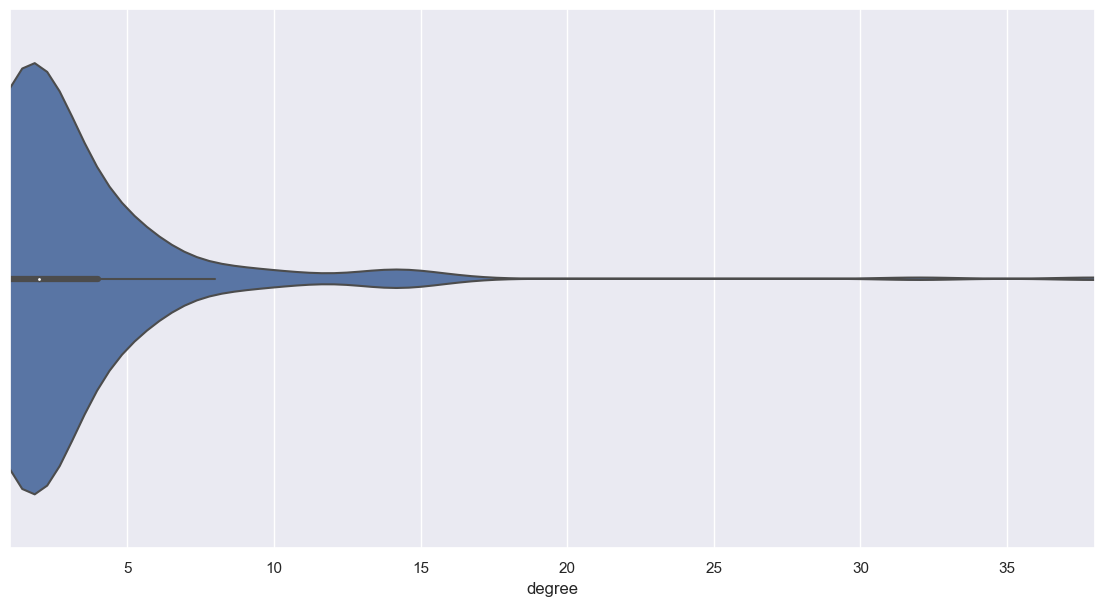

In [204]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

a = export['degree'].dropna()
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


In [205]:
kamo = nx.k_core(amO, k=5)

In [206]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)


(False, True, 18, 54, 0.35294117647058826)

In [207]:
components = nx.connected_components(kamo);
components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
len(components_l), components_l[:5]

(1, [18])

In [208]:
largest_cc = max(nx.connected_components(kamo), key=len)

In [209]:
S = kamo.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

### Représenter le graphe

In [210]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html
u = S
## ,nx.is_connected(G_1971_1975) u.is_directed(),
u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, True, 18, 54, 0.35294117647058826)

In [211]:
list(u.nodes.data())[1:3]

[('London_School_of_Economics',
  {'degree': 5, 'closeness': 0.12990823513476907, 'betweenness': 0.0}),
 ('Chadwick_School',
  {'degree': 5, 'closeness': 0.13015150898333605, 'betweenness': 0.0})]

In [212]:
labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 15:
        labels[i[0]]=i[0] 
list(labels.items())[:3]

[('Columbia_University', 'Columbia_University'),
 ('Harvard_University', 'Harvard_University')]

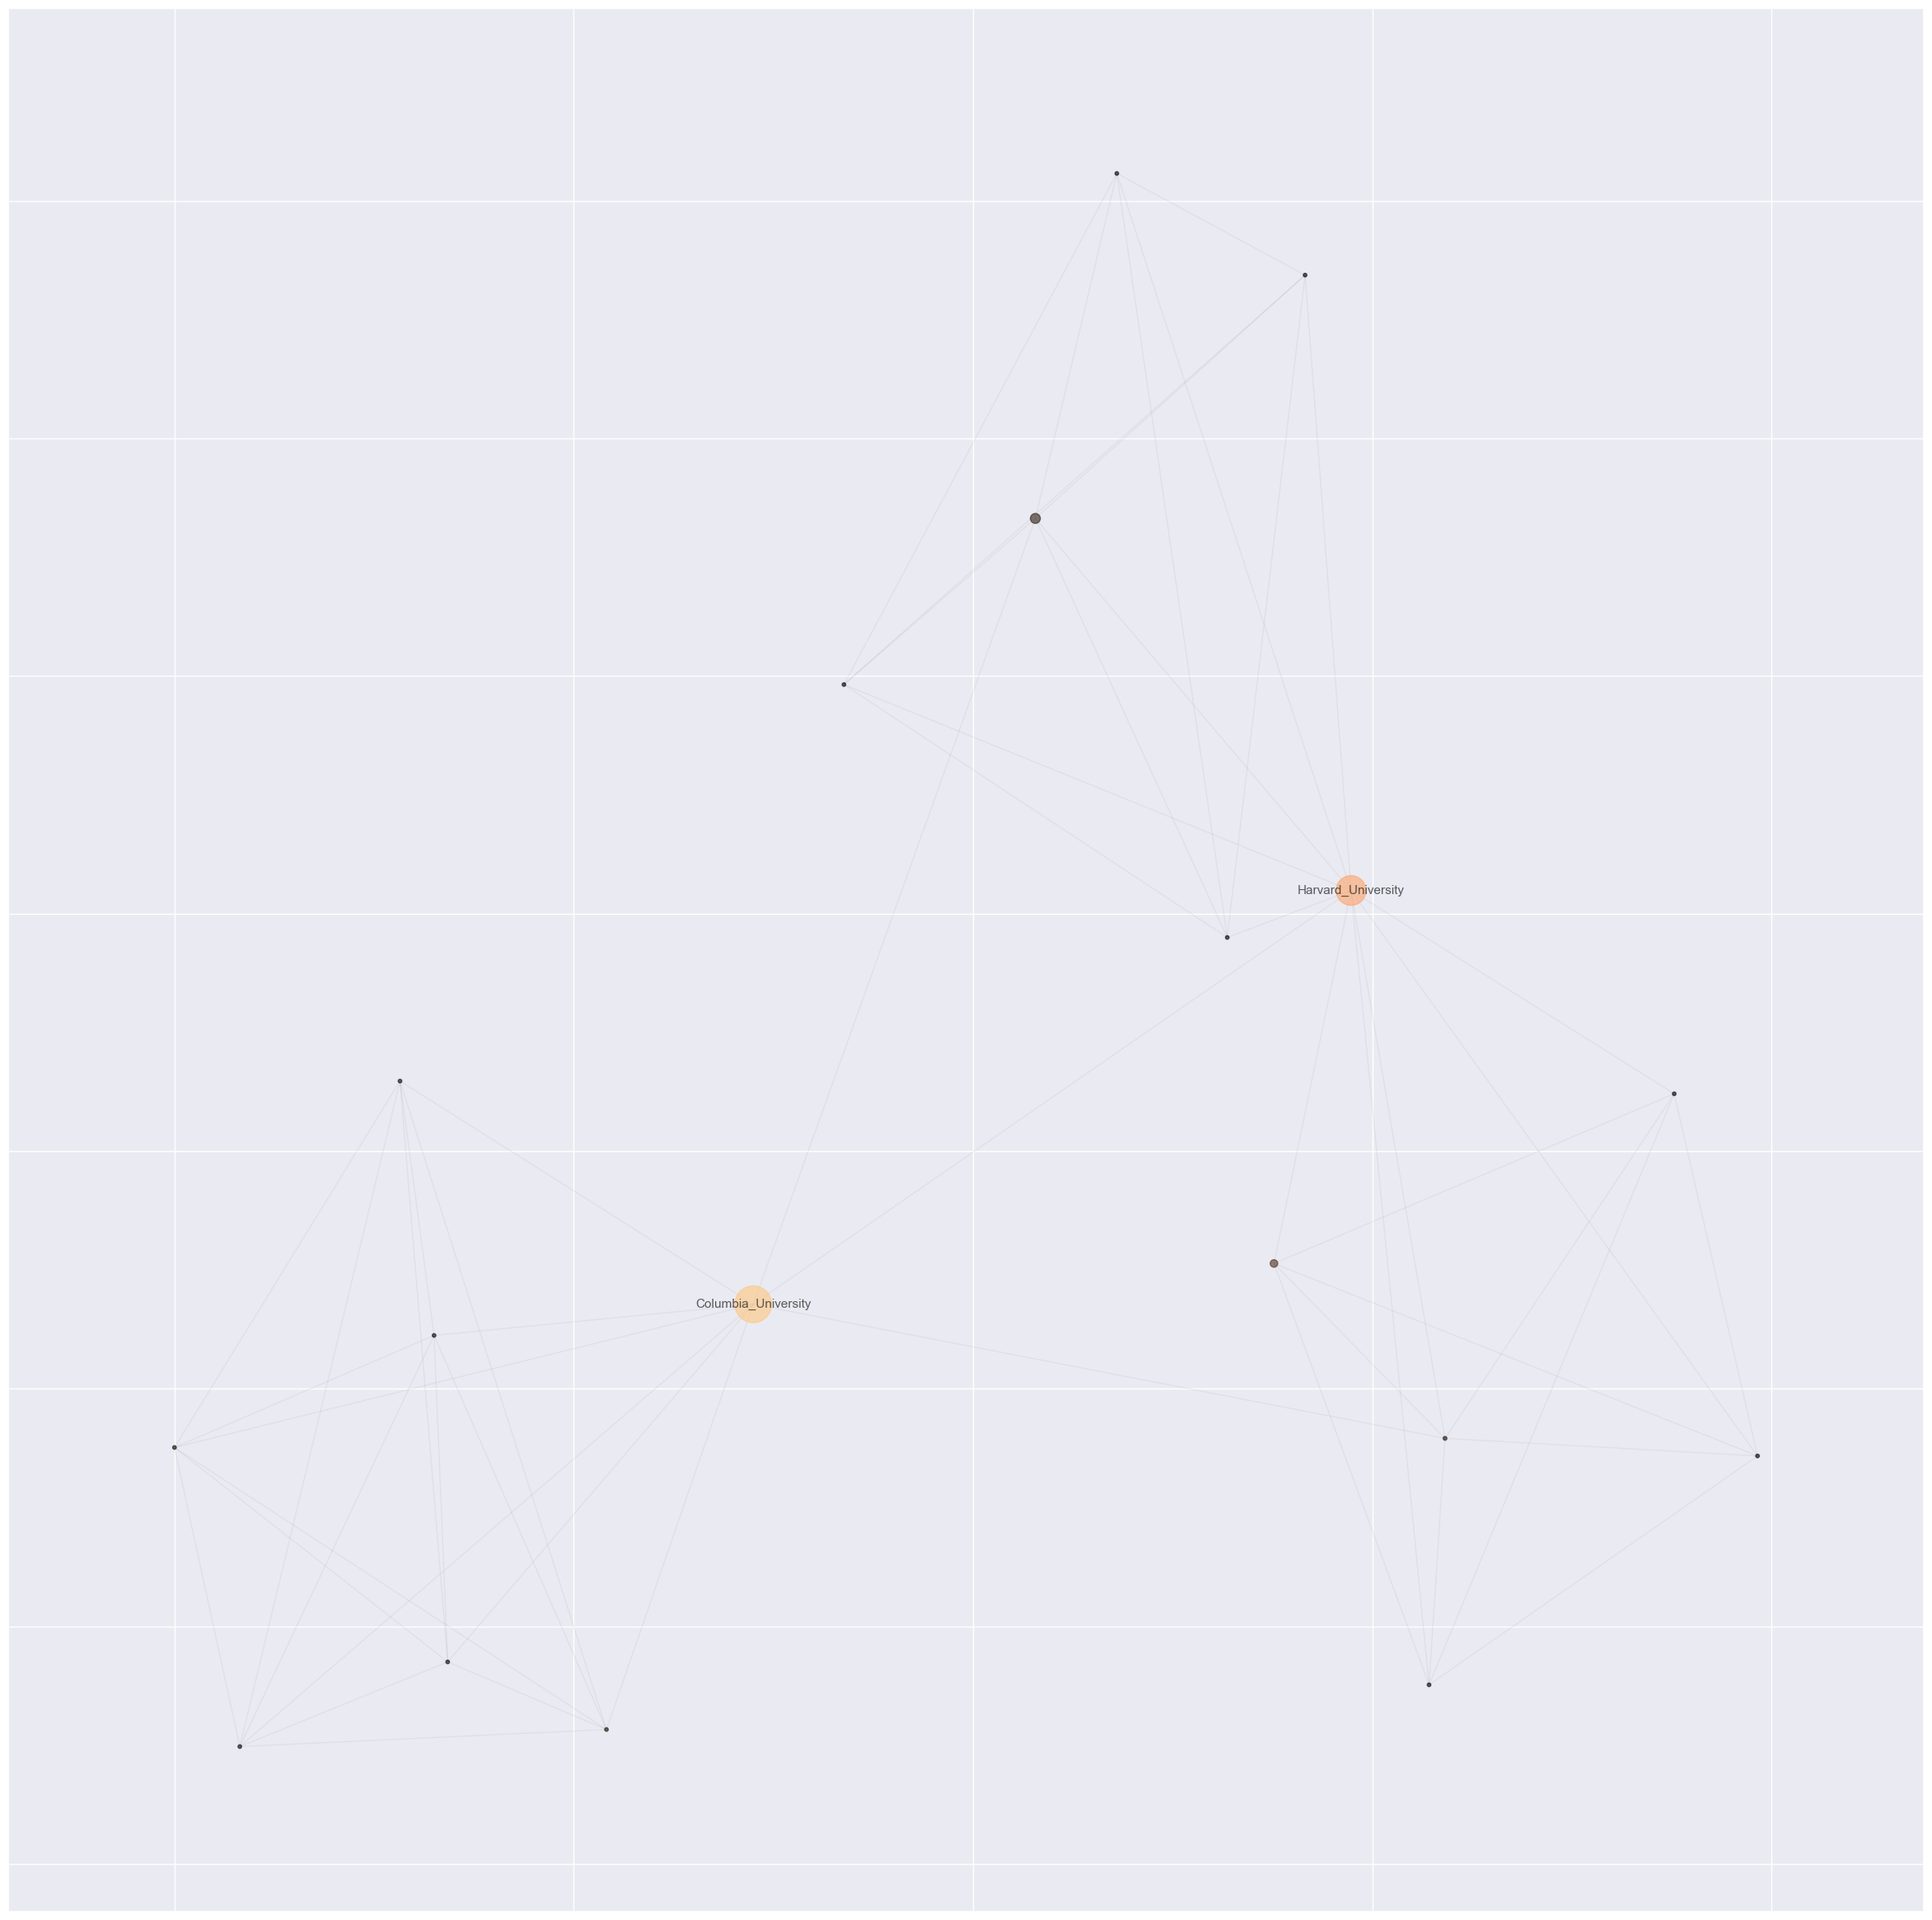

In [213]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 30:
        labels[i[0]]=i[0] 

node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness']**2 * 100000 + 10 for i in list(u.nodes.data())]


cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color, 
                      cmap='copper', alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.05) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

f = 'pictures/universites.svg'# io.BytesIO()

plt.savefig(f, format="svg")

plt.show()
